# Polynomial regression

An example of Gram Schmidt normalization, where each feature is another degree of the polynomial. We use a widely available dataset of the date of peak bloom for the cherry blossoms in D.C. as predicted by the year.

JMA March 2024

In [23]:
# An example of the typical imports for data science notebook
# not all will be used here

# Import python standard library
import re, os, sys, time
import math
from pathlib import Path

# Import array and dataframe packages
import numpy as np
from numpy.random import default_rng
import pandas as pd

# Import ML & stats packages
# import sklearn as sk
# import scipy as sp     # for the binom(n,k) function
# use statsmodels to compute regression standard errors
# scikit learn doesn't compute them.
import statsmodels.api as sm

# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span
from bokeh.io import output_notebook
output_notebook()

In [24]:
# Get access to the file system on Google Drive
from google.colab import drive
drive.mount('/content/drive/')
!ls '/content/drive/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
MyDrive  Shareddrives


In [25]:
# Load the cherry blossom data
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks'
raw_blossom_data = pd.read_csv(Path(DATA_DIR) / Path('cherry-blossoms_fig-1.csv'), header =6)
raw_blossom_data.head()

,Year,Yoshino peak bloom date,Cherry blossom festival start date,Cherry blossom festival duration
0,1921,79,NaN,NaN
1,1922,97,NaN,NaN
2,1923,99,NaN,NaN
3,1924,104,NaN,NaN
4,1925,86,NaN,NaN


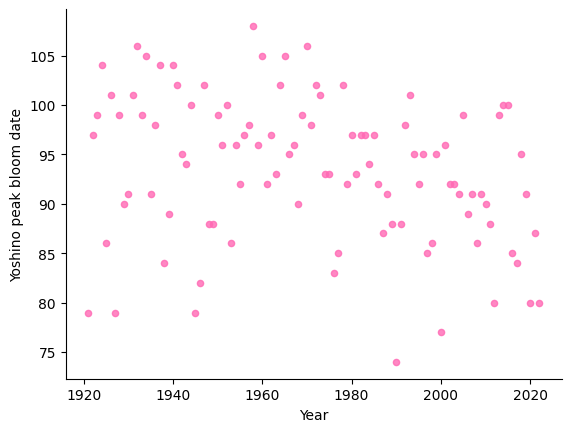

In [26]:
# @title Year vs Yoshino peak bloom date

from matplotlib import pyplot as plt
raw_blossom_data.plot(kind='scatter', x='Year', y='Yoshino peak bloom date', s=20, alpha=.8, color='hotpink')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [27]:
# First, without first orthogonalizing the columns, apply a 3rd degree  polynomial.

outcome = np.array(raw_blossom_data['Yoshino peak bloom date'])

linear = np.array(raw_blossom_data['Year'])
ones = np.ones((len(linear),))
quadratic = np.square(linear)
cube = np.vectorize(lambda x: pow(x, 3))
cubic = cube(linear)

design_matrix = np.vstack([ones, linear, quadratic, cubic]).T

In [28]:
pd.DataFrame(design_matrix).head()

,0,1,2,3
0,1.0,1921.0,3690241.0,7.088953e+09
1,1.0,1922.0,3694084.0,7.100029e+09
2,1.0,1923.0,3697929.0,7.111117e+09
3,1.0,1924.0,3701776.0,7.122217e+09
4,1.0,1925.0,3705625.0,7.133328e+09


In [29]:
polynomial_model = sm.OLS(outcome, design_matrix)
print(polynomial_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     6.869
Date:                Thu, 07 Mar 2024   Prob (F-statistic):            0.00161
Time:                        18:03:09   Log-Likelihood:                -341.44
No. Observations:                 102   AIC:                             688.9
Df Residuals:                      99   BIC:                             696.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.003     -2.018      0.0

In [30]:

predictions = polynomial_model.fit().get_prediction().summary_frame()
xy = predictions.assign(year=linear)

In [31]:
# src.data.keys()
xy.columns

Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower',
       'obs_ci_upper', 'year'],
      dtype='object')

In [32]:

src = ColumnDataSource(xy)
p = figure()
p.line(x= 'year', y='mean', source=src)
p.line(x= 'year', y='obs_ci_lower', source=src, line_dash = 'dotdash')
p.line(x= 'year', y='obs_ci_upper', source=src, line_dash = 'dotdash')
rbd = ColumnDataSource(raw_blossom_data)
p.circle(x = 'Year', y='Yoshino peak bloom date', source=rbd, color='hotpink')
show(p)

# We repeat this regression, but apply a Gram-Schmidt orthogonalization to the polynomial columns

First we'll center the data


In [33]:
centered_blossom_data = pd.DataFrame(dict(
    year=raw_blossom_data['Year'] - raw_blossom_data['Year'].mean(),
    peak_data=raw_blossom_data['Yoshino peak bloom date'] - raw_blossom_data['Yoshino peak bloom date'].mean()))


### Successive regressions, adding orthogonal components


```
Initialize z_0 = 1
For 1 to p:
 regress x_i on z .. z_{i-1}
 z_i <- x_i - \sum \gamma z_{i-1}
Regress y on z_p to get \beta_p
```




In [34]:
def univariate_coef(x, z):
  return x.dot(z) / z.dot(z)

In [53]:
# Create the x and y tables
linear = centered_blossom_data['year'].values
ones = np.ones((len(linear),))
quadratic = np.square(linear)
cube = np.vectorize(lambda x: pow(x, 3))
cubic = cube(linear)

centered_dm = np.vstack([ones, linear, quadratic, cubic]).T

In [68]:
# All we need is the regression coef, which we can obtain by dot products.
cy = centered_blossom_data['peak_data'].values
print('mean peak ', cy.mean())
z = np.empty((len(outcome),4))
z[:,0] = ones

for j in range(1,4):
  # for i in range(i):
  # regress on previous 1..i z values. and assign z the residual.
  z[:,j] = centered_dm[:,j] - sm.OLS(centered_dm[:,j], z[:,0:j]).fit().predict()
  print(j, ';',  sm.OLS(centered_dm[:,j], z[:,0:j]).fit().params)


mean peak  -5.2942399919380015e-15
1 ; [5.55111512e-17]
2 ; [ 8.66916667e+02 -1.77635684e-15]
3 ; [-1.36424205e-12  1.56025000e+03  1.88293825e-13]


In [47]:
pd.DataFrame(z)

,0,1,2,3
0,1.0,-50.5,1683.333333,-49995.0
1,1.0,-49.5,1583.333333,-44055.0
2,1.0,-48.5,1485.333333,-38412.0
3,1.0,-47.5,1389.333333,-33060.0
4,1.0,-46.5,1295.333333,-27993.0
...,...,...,...,...
97,1.0,46.5,1295.333333,27993.0
98,1.0,47.5,1389.333333,33060.0
99,1.0,48.5,1485.333333,38412.0
100,1.0,49.5,1583.333333,44055.0


In [69]:
# Next repeat the regression on the orthogonalized data.
orthogonal_model = sm.OLS(cy, z)
print(orthogonal_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     4.674
Date:                Thu, 07 Mar 2024   Prob (F-statistic):            0.00428
Time:                        18:38:18   Log-Likelihood:                -341.25
No. Observations:                 102   AIC:                             690.5
Df Residuals:                      98   BIC:                             701.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.024e-15      0.694  -7.24e-15      1.0

In [70]:
ortho_predictions = orthogonal_model.fit().get_prediction().summary_frame()
ortho_xy = ortho_predictions.assign(year=linear)
ortho_xy.columns

Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower',
       'obs_ci_upper', 'year'],
      dtype='object')

In [71]:
src = ColumnDataSource(ortho_xy)
p = figure()
p.line(x= 'year', y='mean', source=src)
p.line(x= 'year', y='obs_ci_lower', source=src, line_dash = 'dotdash')
p.line(x= 'year', y='obs_ci_upper', source=src, line_dash = 'dotdash')
rbd = ColumnDataSource(centered_blossom_data)
p.circle(x = 'year', y='peak_data', source=rbd, color='hotpink')
show(p)